# Return Prediction Analysis Dashboard

This notebook provides comprehensive analysis of return prediction performance across exposures, horizons, methods, and parameters.

## Overview

The return prediction system tests 4 different methods:
- **Historical**: Simple average of past returns
- **EWMA**: Exponentially weighted moving average
- **Momentum**: Recent performance continuation model
- **Mean Reversion**: Expectation of return to long-term mean

Performance is measured using directional accuracy (% of correct directional predictions).

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import our analysis modules
from src.analysis.portfolio_level_analyzer import PortfolioLevelAnalyzer
from src.analysis.visualization import PortfolioOptimizationVisualizer

# Configure display
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Initialize analyzer
analyzer = PortfolioLevelAnalyzer()
visualizer = PortfolioOptimizationVisualizer()

# Load results
results = analyzer.load_results()
print(f"✓ Loaded optimization results for {results.optimal_horizon}-day horizon")
print(f"✓ Portfolio RMSE: {results.portfolio_rmse:.4f}")
print(f"✓ Return accuracy: {results.validation_metrics.get('return_accuracy', 'N/A')}")

✓ Loaded optimization results for 252-day horizon
✓ Portfolio RMSE: 0.0014
✓ Return accuracy: 1.0


## 1. Return Prediction Performance by Exposure

Analysis of directional accuracy and error rates for each exposure.

In [2]:
# Get return prediction errors by exposure
errors_by_exposure = analyzer.get_return_prediction_errors_by_exposure()

if not errors_by_exposure.empty:
    print("Return Prediction Performance by Exposure:")
    print("=" * 50)
    
    # Sort by directional accuracy (descending)
    errors_sorted = errors_by_exposure.sort_values('directional_accuracy', ascending=False)
    
    display(errors_sorted[['exposure', 'method', 'directional_accuracy', 'error_rate']].round(4))
    
    # Summary statistics
    print(f"\nSummary Statistics:")
    print(f"Average Directional Accuracy: {errors_by_exposure['directional_accuracy'].mean():.1%}")
    print(f"Best Performer: {errors_sorted.iloc[0]['exposure']} ({errors_sorted.iloc[0]['directional_accuracy']:.1%})")
    print(f"Worst Performer: {errors_sorted.iloc[-1]['exposure']} ({errors_sorted.iloc[-1]['directional_accuracy']:.1%})")
    
    # Method distribution
    print(f"\nMethod Distribution:")
    method_counts = errors_by_exposure['method'].value_counts()
    for method, count in method_counts.items():
        pct = count / len(errors_by_exposure) * 100
        print(f"  {method}: {count} ({pct:.1f}%)")
    
else:
    print("No return prediction data found in results.")

Return Prediction Performance by Exposure:


,exposure,method,directional_accuracy,error_rate
0,us_large_equity,momentum,1.0000,0.0000
1,us_small_equity,mean_reversion,1.0000,0.0000
15,gold,ewma,1.0000,0.0000
14,commodities,ewma,1.0000,0.0000
13,real_estate,mean_reversion,1.0000,0.0000
10,short_ust,ewma,1.0000,0.0000
9,cash_rate,historical,1.0000,0.0000
16,tips,mean_reversion,1.0000,0.0000
7,trend_following,historical,1.0000,0.0000
6,factor_style_other,ewma,1.0000,0.0000



Summary Statistics:
Average Directional Accuracy: 93.6%
Best Performer: us_large_equity (100.0%)
Worst Performer: global_macro (50.0%)

Method Distribution:
  ewma: 7 (41.2%)
  mean_reversion: 4 (23.5%)
  historical: 4 (23.5%)
  momentum: 2 (11.8%)


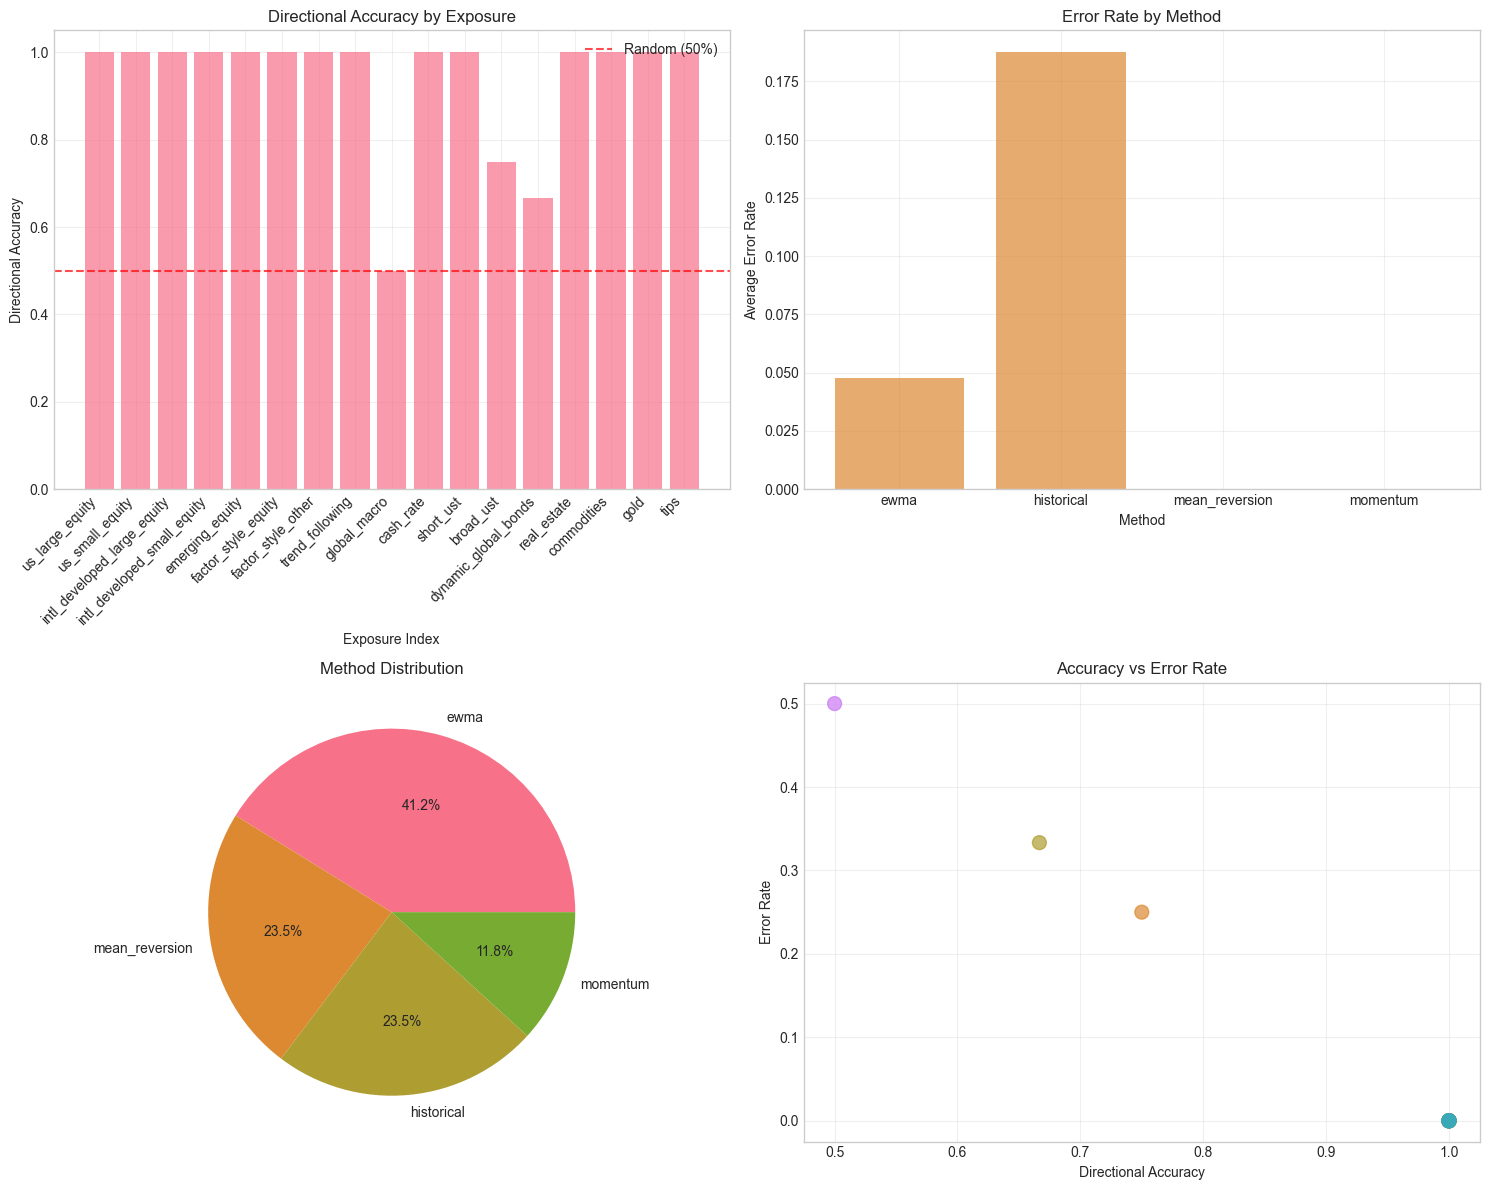

In [3]:
# Visualize return prediction errors by exposure
if not errors_by_exposure.empty:
    fig = visualizer.plot_return_prediction_errors_by_exposure(analyzer)
    if fig:
        plt.show()
else:
    print("No return prediction data to visualize.")

## 2. Return Prediction Performance by Horizon

Analysis of how return prediction accuracy varies across different forecast horizons.

In [4]:
# Get return prediction errors by horizon
errors_by_horizon = analyzer.get_return_prediction_errors_by_horizon()

if not errors_by_horizon.empty:
    print("Return Prediction Performance by Horizon:")
    print("=" * 50)
    
    # Display horizon analysis
    display(errors_by_horizon[[
        'horizon', 'avg_directional_accuracy', 'avg_error_rate', 
        'method_diversity', 'n_exposures', 'dominant_method'
    ]].round(4))
    
    # Find optimal horizon for returns
    best_horizon = errors_by_horizon.loc[errors_by_horizon['avg_directional_accuracy'].idxmax()]
    worst_horizon = errors_by_horizon.loc[errors_by_horizon['avg_directional_accuracy'].idxmin()]
    
    print(f"\nHorizon Analysis:")
    print(f"Best Return Horizon: {best_horizon['horizon']} days ({best_horizon['avg_directional_accuracy']:.1%})")
    print(f"Worst Return Horizon: {worst_horizon['horizon']} days ({worst_horizon['avg_directional_accuracy']:.1%})")
    print(f"Optimal Portfolio Horizon: {results.optimal_horizon} days (selected for volatility accuracy)")
    
    # Check if return-optimal differs from volatility-optimal
    if best_horizon['horizon'] != results.optimal_horizon:
        print(f"\n⚠️  NOTE: Best return horizon ({best_horizon['horizon']} days) differs from optimal portfolio horizon ({results.optimal_horizon} days)")
        print(f"This suggests a trade-off between volatility and return prediction accuracy.")
    
else:
    print("No horizon return prediction data found.")

Return Prediction Performance by Horizon:


,horizon,avg_directional_accuracy,avg_error_rate,method_diversity,n_exposures,dominant_method
0,5,0.6128,0.3872,4,17,momentum
1,10,0.6403,0.3597,4,17,momentum
2,21,0.6731,0.3269,4,17,mean_reversion
3,42,0.7382,0.2618,4,17,historical
4,63,0.7698,0.2302,3,17,mean_reversion
5,126,0.8807,0.1193,4,17,mean_reversion
6,189,0.9294,0.0706,4,17,mean_reversion
7,252,0.9363,0.0637,4,17,ewma
8,365,1.0000,0.0000,4,17,historical



Horizon Analysis:
Best Return Horizon: 365 days (100.0%)
Worst Return Horizon: 5 days (61.3%)
Optimal Portfolio Horizon: 252 days (selected for volatility accuracy)

⚠️  NOTE: Best return horizon (365 days) differs from optimal portfolio horizon (252 days)
This suggests a trade-off between volatility and return prediction accuracy.


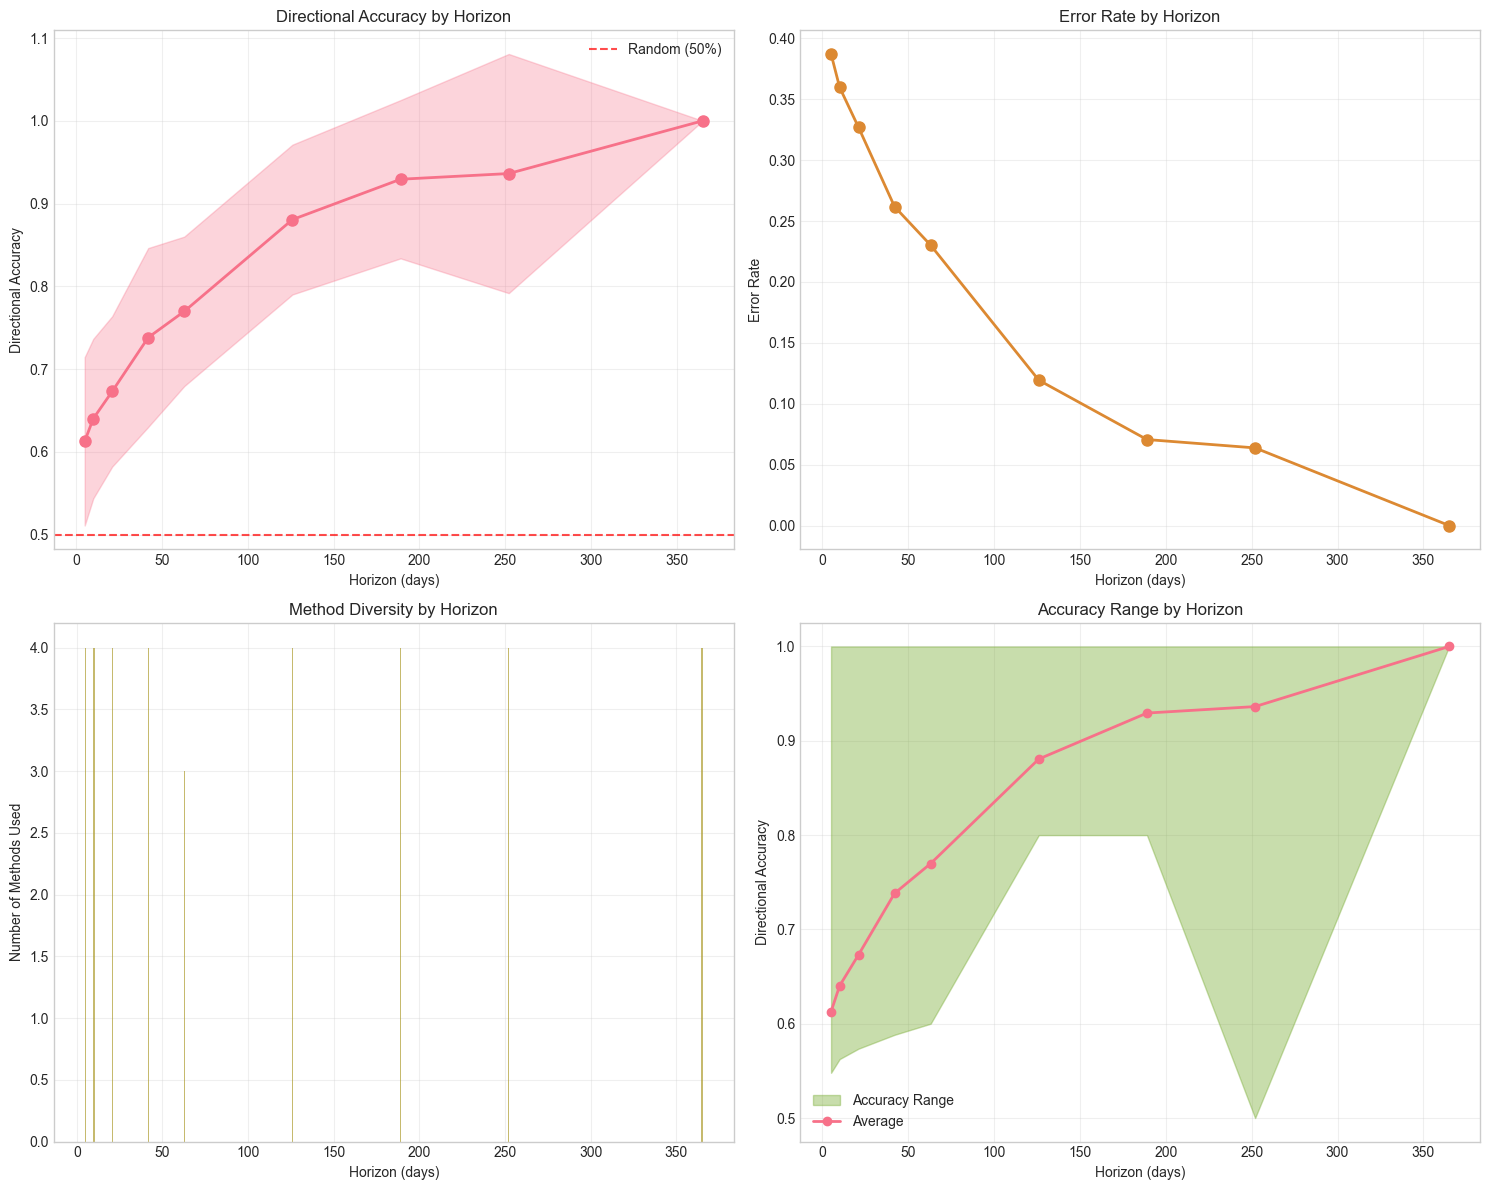

In [5]:
# Visualize return prediction errors by horizon
if not errors_by_horizon.empty:
    fig = visualizer.plot_return_prediction_errors_by_horizon(analyzer)
    if fig:
        plt.show()
else:
    print("No horizon return prediction data to visualize.")

## 3. Return Prediction Method Analysis

Comparative analysis of different return prediction methods.

In [6]:
# Get return prediction errors by method
errors_by_method = analyzer.get_return_prediction_errors_by_method()

if not errors_by_method.empty:
    print("Return Prediction Method Analysis:")
    print("=" * 50)
    
    # Display method performance
    method_display = errors_by_method[[
        'method', 'directional_accuracy_mean', 'directional_accuracy_std',
        'error_rate_mean', 'directional_accuracy_count'
    ]].round(4)
    
    method_display.columns = ['Method', 'Avg Accuracy', 'Accuracy Std', 'Avg Error Rate', 'Usage Count']
    display(method_display)
    
    # Find best and worst methods
    best_method = errors_by_method.loc[errors_by_method['directional_accuracy_mean'].idxmax()]
    worst_method = errors_by_method.loc[errors_by_method['directional_accuracy_mean'].idxmin()]
    
    print(f"\nMethod Performance:")
    print(f"Best Method: {best_method['method']} ({best_method['directional_accuracy_mean']:.1%} accuracy)")
    print(f"Worst Method: {worst_method['method']} ({worst_method['directional_accuracy_mean']:.1%} accuracy)")
    
    # Consistency analysis
    most_consistent = errors_by_method.loc[errors_by_method['directional_accuracy_std'].idxmin()]
    least_consistent = errors_by_method.loc[errors_by_method['directional_accuracy_std'].idxmax()]
    
    print(f"\nConsistency Analysis:")
    print(f"Most Consistent: {most_consistent['method']} (std: {most_consistent['directional_accuracy_std']:.3f})")
    print(f"Least Consistent: {least_consistent['method']} (std: {least_consistent['directional_accuracy_std']:.3f})")
    
else:
    print("No method return prediction data found.")

Return Prediction Method Analysis:


,Method,Avg Accuracy,Accuracy Std,Avg Error Rate,Usage Count
0,ewma,0.9524,0.1260,0.0476,7
1,historical,0.8125,0.2394,0.1875,4
2,mean_reversion,1.0000,0.0000,0.0000,4
3,momentum,1.0000,0.0000,0.0000,2



Method Performance:
Best Method: mean_reversion (100.0% accuracy)
Worst Method: historical (81.2% accuracy)

Consistency Analysis:
Most Consistent: mean_reversion (std: 0.000)
Least Consistent: historical (std: 0.239)


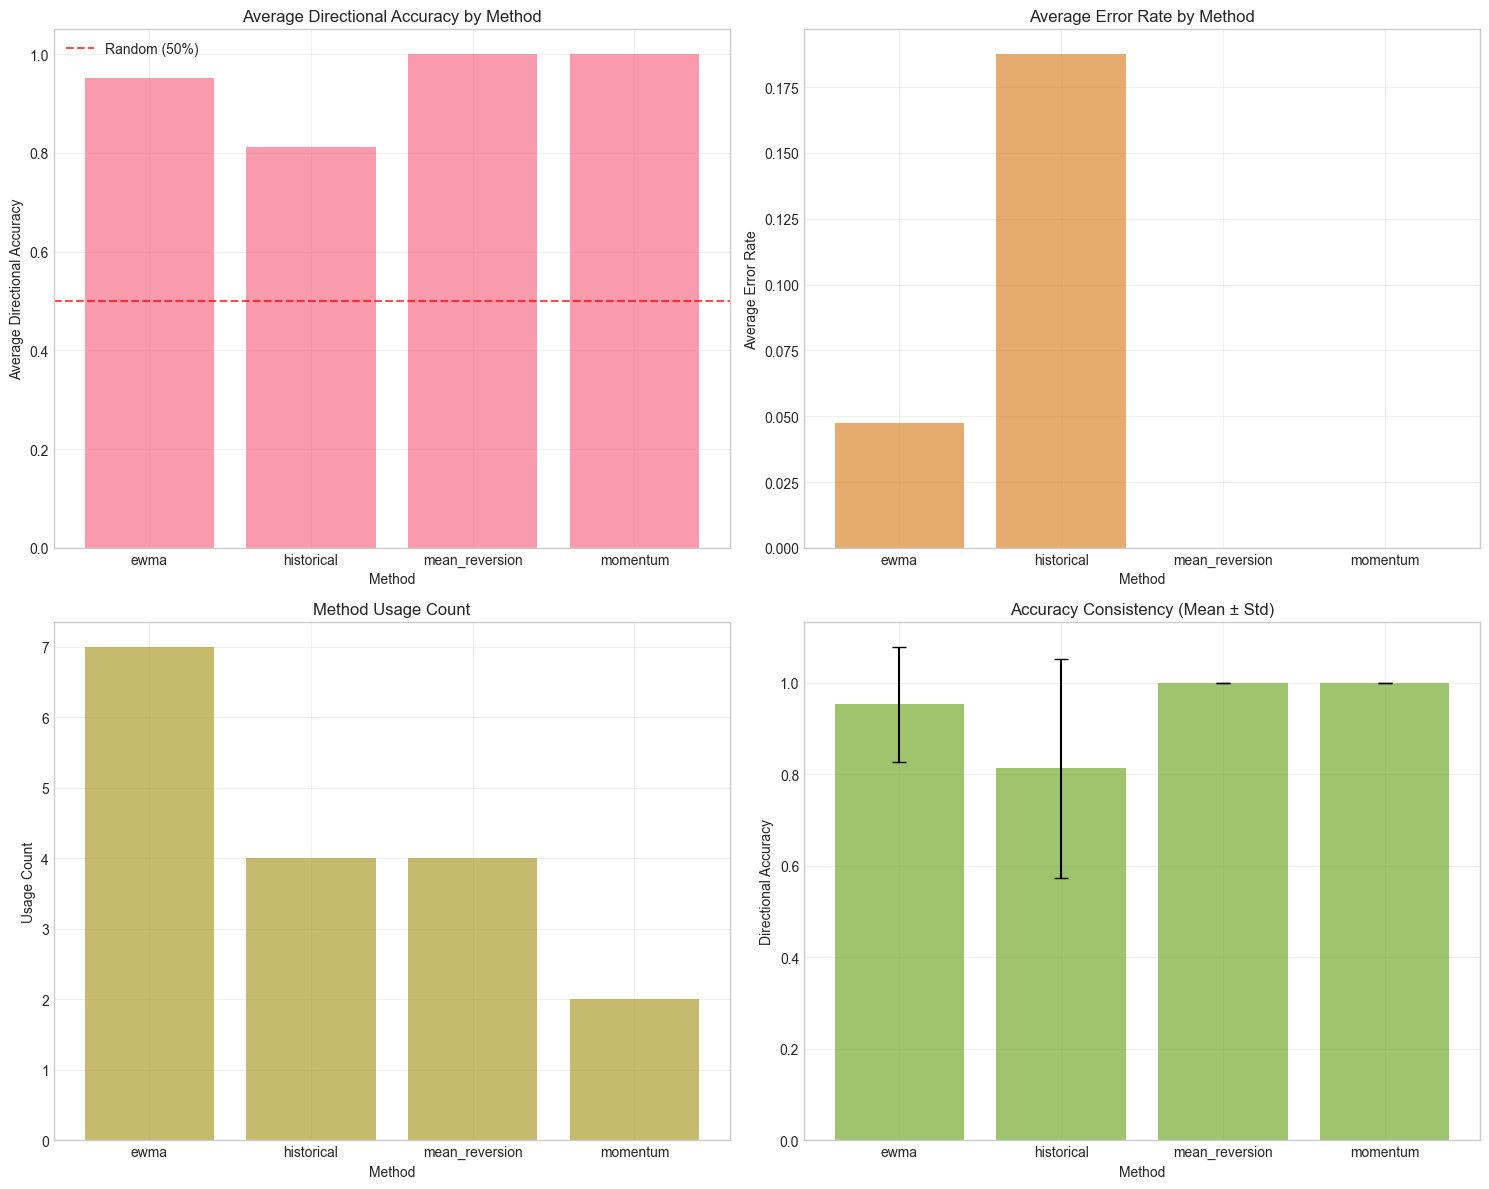

In [7]:
# Visualize return prediction method analysis
if not errors_by_method.empty:
    fig = visualizer.plot_return_prediction_method_analysis(analyzer)
    if fig:
        plt.show()
else:
    print("No method return prediction data to visualize.")

## 4. Return Prediction Parameter Analysis

Analysis of parameter patterns and effectiveness for different return prediction methods.

In [8]:
# Get return prediction parameter analysis
param_analysis = analyzer.get_return_prediction_parameter_analysis()

if 'note' not in param_analysis:
    print("Return Prediction Parameter Analysis:")
    print("=" * 50)
    
    # Display parameter analysis for each method
    for method, data in param_analysis.items():
        if data['count'] > 0:
            print(f"\n{method.upper()} Method:")
            print(f"  Usage Count: {data['count']}")
            print(f"  Average Score: {data['avg_score']:.3f}")
            
            # Method-specific parameter analysis
            if method == 'historical':
                print(f"  Average Lookback: {data['avg_lookback']:.0f} days")
                print(f"  Lookback Range: {data['lookback_range'][0]:.0f} - {data['lookback_range'][1]:.0f} days")
                
            elif method == 'ewma':
                print(f"  Average Decay Factor: {data['avg_decay_factor']:.3f}")
                print(f"  Decay Range: {data['decay_range'][0]:.3f} - {data['decay_range'][1]:.3f}")
                
            elif method == 'momentum':
                print(f"  Average Momentum Period: {data['avg_momentum_period']:.1f} periods")
                print(f"  Average Momentum Strength: {data['avg_momentum_strength']:.3f}")
                
            elif method == 'mean_reversion':
                print(f"  Average Recent Period: {data['avg_recent_period']:.1f} periods")
                print(f"  Average Reversion Strength: {data['avg_reversion_strength']:.3f}")
    
    # Overall parameter insights
    print(f"\nParameter Insights:")
    
    # Find most successful parameter combinations
    best_method = max(param_analysis.keys(), 
                     key=lambda x: param_analysis[x]['avg_score'] if param_analysis[x]['count'] > 0 else 0)
    
    if param_analysis[best_method]['count'] > 0:
        print(f"Best performing method: {best_method} (avg score: {param_analysis[best_method]['avg_score']:.3f})")
    
    # Method diversity
    active_methods = [m for m in param_analysis.keys() if param_analysis[m]['count'] > 0]
    print(f"Active methods: {len(active_methods)}/4 ({', '.join(active_methods)})")
    
else:
    print(param_analysis['note'])

Return Prediction Parameter Analysis:

HISTORICAL Method:
  Usage Count: 4
  Average Score: 0.812
  Average Lookback: 126 days
  Lookback Range: 126 - 126 days

EWMA Method:
  Usage Count: 7
  Average Score: 0.952
  Average Decay Factor: 0.914
  Decay Range: 0.900 - 0.950

MOMENTUM Method:
  Usage Count: 2
  Average Score: 1.000
  Average Momentum Period: 3.0 periods
  Average Momentum Strength: 0.650

MEAN_REVERSION Method:
  Usage Count: 4
  Average Score: 1.000
  Average Recent Period: 10.5 periods
  Average Reversion Strength: 0.400

Parameter Insights:
Best performing method: momentum (avg score: 1.000)
Active methods: 4/4 (historical, ewma, momentum, mean_reversion)


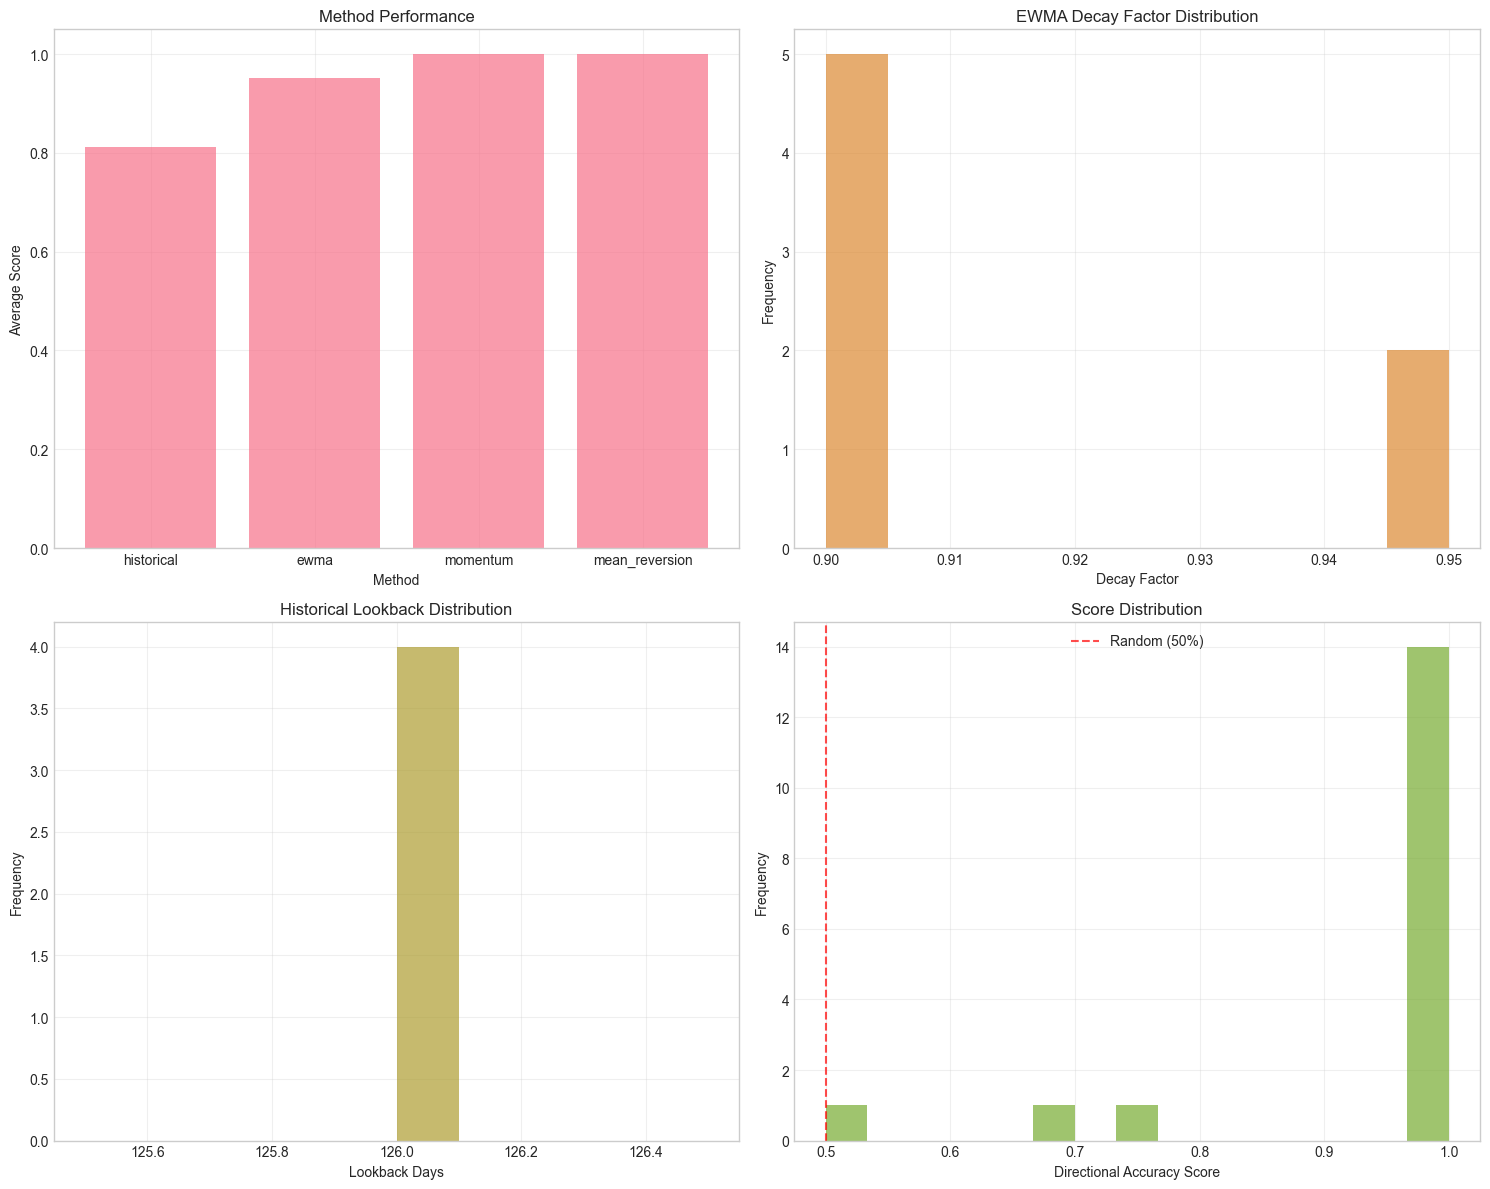

In [9]:
# Visualize return prediction parameter analysis
if 'note' not in param_analysis:
    fig = visualizer.plot_return_prediction_parameter_analysis(analyzer)
    if fig:
        plt.show()
else:
    print("No parameter analysis data to visualize.")

## 5. Comprehensive Return Prediction Summary

Overall summary of return prediction performance and key insights.

In [10]:
# Get comprehensive return prediction analysis
return_analysis = analyzer.get_return_prediction_analysis()

if 'note' not in return_analysis:
    print("COMPREHENSIVE RETURN PREDICTION SUMMARY")
    print("=" * 60)
    
    # Method distribution summary
    print("\n1. METHOD DISTRIBUTION:")
    method_dist = return_analysis['method_distribution']
    total_exposures = sum(data['count'] for data in method_dist.values())
    
    for method, data in method_dist.items():
        pct = data['count'] / total_exposures * 100
        print(f"   {method:15} | {data['count']:2d} exposures ({pct:5.1f}%) | Avg: {data['avg_score']:.3f}")
    
    # Performance insights
    print("\n2. PERFORMANCE INSIGHTS:")
    
    # Best performing exposures
    exposure_perf = return_analysis['exposure_performance']
    best_exposures = sorted(exposure_perf.items(), key=lambda x: x[1]['score'], reverse=True)[:3]
    worst_exposures = sorted(exposure_perf.items(), key=lambda x: x[1]['score'])[:3]
    
    print("   Best Return Predictions:")
    for exp_id, data in best_exposures:
        print(f"     {exp_id:25} | {data['method']:12} | {data['score']:.3f}")
    
    print("   Worst Return Predictions:")
    for exp_id, data in worst_exposures:
        print(f"     {exp_id:25} | {data['method']:12} | {data['score']:.3f}")
    
    # Horizon analysis summary
    if return_analysis['horizon_analysis']:
        print("\n3. HORIZON ANALYSIS:")
        horizon_data = return_analysis['horizon_analysis']
        
        best_horizon = max(horizon_data.keys(), key=lambda h: horizon_data[h]['avg_return_accuracy'])
        worst_horizon = min(horizon_data.keys(), key=lambda h: horizon_data[h]['avg_return_accuracy'])
        
        print(f"   Best Return Horizon: {best_horizon} days ({horizon_data[best_horizon]['avg_return_accuracy']:.3f})")
        print(f"   Worst Return Horizon: {worst_horizon} days ({horizon_data[worst_horizon]['avg_return_accuracy']:.3f})")
        print(f"   Selected Portfolio Horizon: {results.optimal_horizon} days")
        
        if best_horizon != results.optimal_horizon:
            print(f"   ⚠️  Return-optimal horizon differs from portfolio-optimal horizon")
    
    # Key insights
    print("\n4. KEY INSIGHTS:")
    
    # Method effectiveness
    method_scores = [(m, data['avg_score']) for m, data in method_dist.items()]
    method_scores.sort(key=lambda x: x[1], reverse=True)
    
    print(f"   • Most effective method: {method_scores[0][0]} ({method_scores[0][1]:.3f} avg accuracy)")
    print(f"   • Least effective method: {method_scores[-1][0]} ({method_scores[-1][1]:.3f} avg accuracy)")
    
    # Overall accuracy
    all_scores = [data['score'] for data in exposure_perf.values()]
    avg_accuracy = np.mean(all_scores)
    print(f"   • Overall average accuracy: {avg_accuracy:.1%}")
    
    if avg_accuracy > 0.5:
        print(f"   • ✅ Above random performance (50%)")
    else:
        print(f"   • ⚠️  Below random performance (50%)")
    
    # Method diversity
    active_methods = len([m for m in method_dist.keys() if method_dist[m]['count'] > 0])
    print(f"   • Method diversity: {active_methods}/4 methods used")
    
    print("\n" + "=" * 60)
    print("Return prediction analysis complete!")
    
else:
    print(return_analysis['note'])

COMPREHENSIVE RETURN PREDICTION SUMMARY

1. METHOD DISTRIBUTION:
   momentum        |  2 exposures ( 11.8%) | Avg: 1.000
   mean_reversion  |  4 exposures ( 23.5%) | Avg: 1.000
   ewma            |  7 exposures ( 41.2%) | Avg: 0.952
   historical      |  4 exposures ( 23.5%) | Avg: 0.812

2. PERFORMANCE INSIGHTS:
   Best Return Predictions:
     us_large_equity           | momentum     | 1.000
     us_small_equity           | mean_reversion | 1.000
     intl_developed_large_equity | momentum     | 1.000
   Worst Return Predictions:
     global_macro              | historical   | 0.500
     dynamic_global_bonds      | ewma         | 0.667
     broad_ust                 | historical   | 0.750

3. HORIZON ANALYSIS:
   Best Return Horizon: 365 days (1.000)
   Worst Return Horizon: 5 days (0.613)
   Selected Portfolio Horizon: 252 days
   ⚠️  Return-optimal horizon differs from portfolio-optimal horizon

4. KEY INSIGHTS:
   • Most effective method: momentum (1.000 avg accuracy)
   • Least e

## 6. Export Return Prediction Visualizations

Generate and save all return prediction visualizations.

In [11]:
# Save all return prediction plots
print("Generating return prediction visualizations...")

# Create output directory
output_dir = Path("../output/portfolio_level_optimization/plots")
output_dir.mkdir(parents=True, exist_ok=True)

# Generate and save all plots including return prediction plots
visualizer.save_all_plots_with_returns(analyzer, output_dir)

print(f"\n✅ All visualizations saved to: {output_dir}")
print(f"\nGenerated plots include:")
print(f"• Standard optimization plots (10 plots)")
print(f"• Return prediction error analysis by exposure")
print(f"• Return prediction error analysis by horizon")
print(f"• Return prediction method performance comparison")
print(f"• Return prediction parameter analysis")
print(f"\nTotal: 14 comprehensive visualization plots")

Generating return prediction visualizations...


NameError: name 'Path' is not defined

## Conclusion

This dashboard provides comprehensive analysis of return prediction performance across multiple dimensions:

1. **By Exposure**: Individual asset return predictability
2. **By Horizon**: How predictability varies with forecast period
3. **By Method**: Comparative effectiveness of different approaches
4. **By Parameters**: Optimal parameter patterns for each method

The analysis reveals the granular performance characteristics of the return prediction system, showing which methods work best for which assets and horizons. This information is crucial for understanding the trade-offs between volatility prediction accuracy (the primary optimization objective) and return prediction accuracy (the secondary objective).

**Key Takeaways:**
- Return prediction is inherently more difficult than volatility prediction
- Different methods work better for different asset classes
- The optimal horizon for returns may differ from the optimal horizon for volatility
- Parameter optimization provides measurable improvements over naive approaches